In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
import pandas as pd

df = pd.read_csv("sri_lanka_western_colombo_1_month_rainfall_aggregate_first_period 1.csv")
df.head()

,Date,1_month_rainfall_aggregate
0,1/1/1981,NaN
1,11/1/1981,NaN
2,21/1/1981,75.3478
3,1/2/1981,62.2609
4,11/2/1981,62.2609


In [3]:
df = df.set_index(pd.to_datetime(df['Date'], format="%d/%m/%Y"))
df = df.dropna()

df.head()

,Date,1_month_rainfall_aggregate
Date,,
1981-01-21,21/1/1981,75.3478
1981-02-01,1/2/1981,62.2609
1981-02-11,11/2/1981,62.2609
1981-02-21,21/2/1981,69.6522
1981-03-01,1/3/1981,36.7391


In [4]:
df = df.drop(columns=['Date'])
df.head()

,1_month_rainfall_aggregate
Date,
1981-01-21,75.3478
1981-02-01,62.2609
1981-02-11,62.2609
1981-02-21,69.6522
1981-03-01,36.7391


In [5]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [6]:
win_df = series_to_supervised(df, 5, 1)
win_df

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
Date,,,,,,
1981-03-11,75.3478,62.2609,62.2609,69.6522,36.7391,47.0000
1981-03-21,62.2609,62.2609,69.6522,36.7391,47.0000,97.5652
1981-04-01,62.2609,69.6522,36.7391,47.0000,97.5652,148.4783
1981-04-11,69.6522,36.7391,47.0000,97.5652,148.4783,170.0435
1981-04-21,36.7391,47.0000,97.5652,148.4783,170.0435,151.1304
...,...,...,...,...,...,...
2024-01-11,574.5652,464.6957,444.2174,335.3478,343.7826,221.5217
2024-01-21,464.6957,444.2174,335.3478,343.7826,221.5217,182.3913
2024-02-01,444.2174,335.3478,343.7826,221.5217,182.3913,54.8261


In [7]:
import numpy as np

def windowed_df_to_date_X_y(windowed_dataframe):
    dates = windowed_dataframe.index.values
    
    df_as_np = windowed_dataframe.to_numpy()

    # dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, :-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(win_df)

dates.shape, X.shape, y.shape

((1547,), (1547, 5, 1), (1547,))

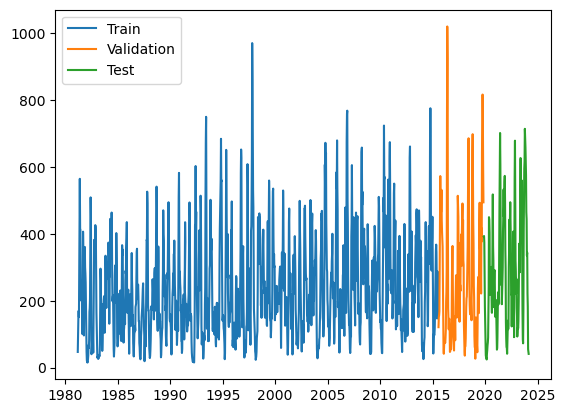

In [8]:
import matplotlib.pyplot as plt

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import *

model = Sequential([layers.Input((5, 1)),
                    layers.LSTM(32),
                    layers.Dense(32, activation='relu'),
                   
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.summary()


model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

hist = model.fit(X_train, y_train,batch_size=5, validation_data=(X_val, y_val), epochs=200)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,497 (25.38 KB)

 Trainable params: 6,497 (25.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 74048.6641 - mean_absolute_error: 224.9066 - val_loss: 32833.2227 - val_mean_absolute_error: 122.9362
Epoch 2/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 13511.8564 - mean_absolute_error: 82.0774 - val_loss: 14368.3076 - val_mean_absolute_error: 78.0297
Epoch 3/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7803.9258 - mean_absolute_error: 63.5243 - val_loss: 12783.3711 - val_mean_absolute_error: 81.1436
Epoch 4/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6475.4771 - mean_absolute_error: 60.1123 - val_loss: 13728.9824 - val_mean_absolute_error: 75.6962
Epoch 5/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7411.5088 - mean_absolute_error: 63.5133 - val_loss: 11364.2979 - val_mean_absolute_error: 69.9441
Epoch 6/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6332.7759 - mean_absolute_error: 59.0467 - val_loss: 9466.7598 - val_mean_absolute_error: 65.3990
Epoch 7/200
248/248 ━━━━━━━━━━━━━━━━

248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5319.0859 - mean_absolute_error: 55.6364 - val_loss: 8908.1562 - val_mean_absolute_error: 67.4640
Epoch 44/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5273.9341 - mean_absolute_error: 55.2798 - val_loss: 8468.5703 - val_mean_absolute_error: 66.2983
Epoch 45/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5152.6250 - mean_absolute_error: 54.2342 - val_loss: 8174.5430 - val_mean_absolute_error: 63.7971
Epoch 46/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 4843.8257 - mean_absolute_error: 52.8341 - val_loss: 8120.4185 - val_mean_absolute_error: 62.8152
Epoch 47/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5786.9785 - mean_absolute_error: 57.6112 - val_loss: 15838.4570 - val_mean_absolute_error: 82.3346
Epoch 48/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5221.3491 - mean_absolute_error: 54.8277 - val_loss: 9501.6455 - val_mean_absolute_error: 65.9796
Epoch 49/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/s

248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5955.8511 - mean_absolute_error: 56.3538 - val_loss: 10134.7246 - val_mean_absolute_error: 67.1057
Epoch 86/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6126.2573 - mean_absolute_error: 57.0272 - val_loss: 9197.7451 - val_mean_absolute_error: 64.3596
Epoch 87/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4968.2935 - mean_absolute_error: 52.4758 - val_loss: 8775.6045 - val_mean_absolute_error: 61.0555
Epoch 88/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5080.1855 - mean_absolute_error: 54.0781 - val_loss: 8335.0928 - val_mean_absolute_error: 61.9771
Epoch 89/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5210.0781 - mean_absolute_error: 53.5135 - val_loss: 8869.4824 - val_mean_absolute_error: 66.2609
Epoch 90/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4884.7534 - mean_absolute_error: 52.2392 - val_loss: 10276.5732 - val_mean_absolute_error: 66.9576
Epoch 91/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/st

248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5924.3062 - mean_absolute_error: 57.9471 - val_loss: 8833.2100 - val_mean_absolute_error: 69.0130
Epoch 128/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5114.7505 - mean_absolute_error: 52.2293 - val_loss: 8718.1836 - val_mean_absolute_error: 63.1617
Epoch 129/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4867.0483 - mean_absolute_error: 52.1012 - val_loss: 11238.5146 - val_mean_absolute_error: 70.4590
Epoch 130/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5555.7256 - mean_absolute_error: 55.0005 - val_loss: 10471.7490 - val_mean_absolute_error: 69.4279
Epoch 131/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5515.8604 - mean_absolute_error: 55.1836 - val_loss: 7919.4336 - val_mean_absolute_error: 62.2418
Epoch 132/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5298.4375 - mean_absolute_error: 55.5656 - val_loss: 8847.7119 - val_mean_absolute_error: 63.7942
Epoch 133/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 

248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4421.4385 - mean_absolute_error: 48.8691 - val_loss: 9784.4023 - val_mean_absolute_error: 67.9884
Epoch 170/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5122.2646 - mean_absolute_error: 53.5953 - val_loss: 8262.3691 - val_mean_absolute_error: 63.2569
Epoch 171/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5580.0137 - mean_absolute_error: 56.1624 - val_loss: 8855.7129 - val_mean_absolute_error: 64.2436
Epoch 172/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5089.2256 - mean_absolute_error: 52.6499 - val_loss: 9216.0361 - val_mean_absolute_error: 69.0338
Epoch 173/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6142.1113 - mean_absolute_error: 57.2913 - val_loss: 12269.0352 - val_mean_absolute_error: 72.5706
Epoch 174/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5920.2021 - mean_absolute_error: 56.2150 - val_loss: 9775.1650 - val_mean_absolute_error: 72.0344
Epoch 175/200
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


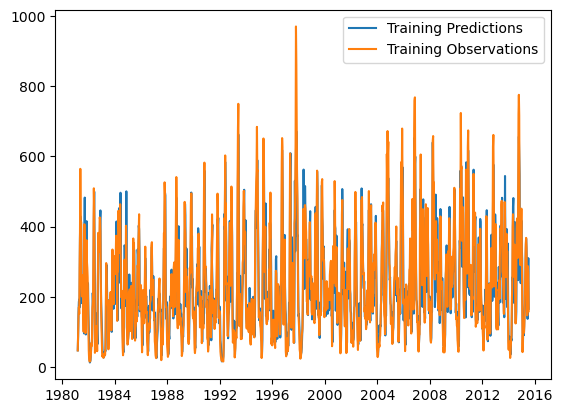

In [10]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


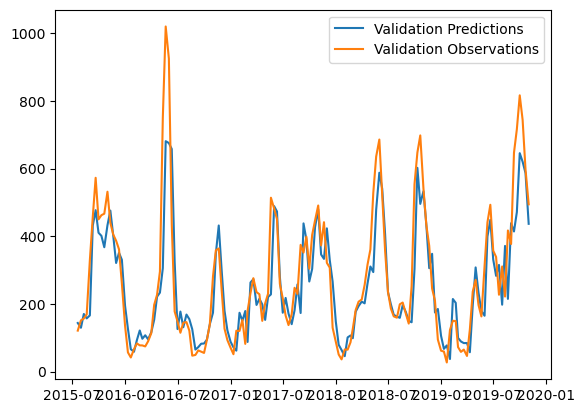

In [11]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


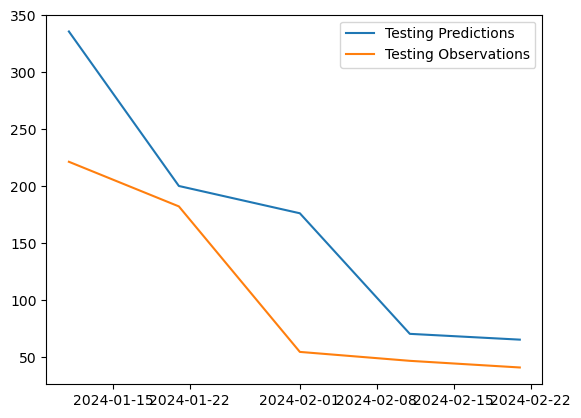

In [12]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test[150:], test_predictions[150:])
plt.plot(dates_test[150:], y_test[150:])
plt.legend(['Testing Predictions', 'Testing Observations'])

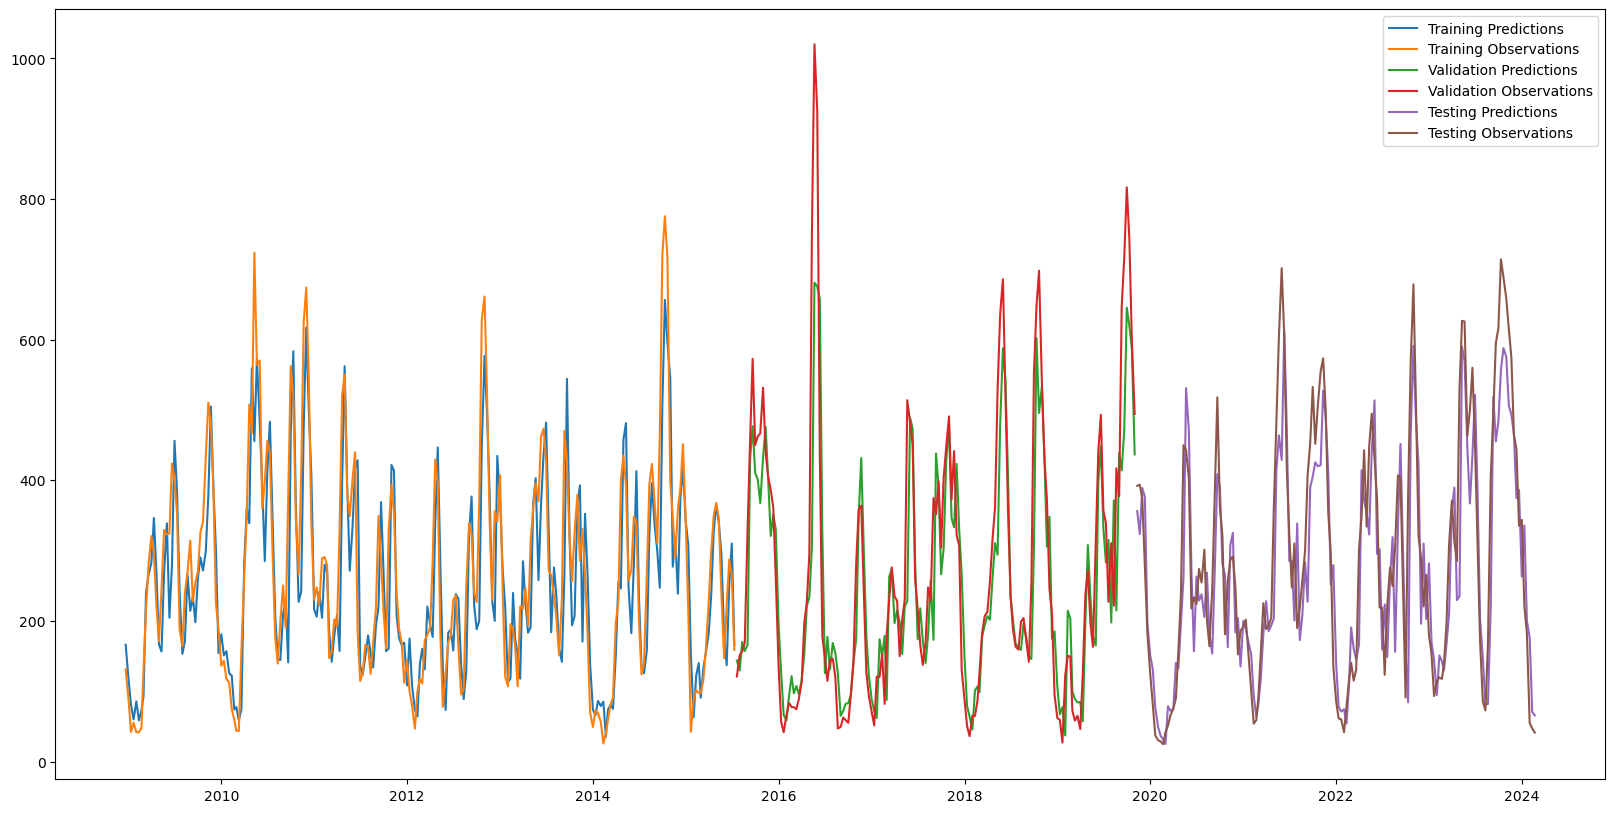

In [13]:
plt.figure(figsize=(20,10))
plt.plot(dates_train[1000:], train_predictions[1000:])
plt.plot(dates_train[1000:], y_train[1000:])
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

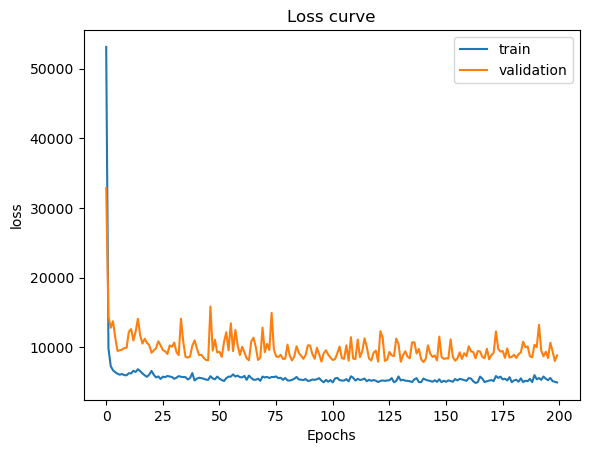

In [14]:
# hist.history
plt.title("Loss curve")
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [15]:
import numpy as np

# Assuming actual_values and predicted_values are the actual and predicted values
actual_values = y_test
predicted_values = test_predictions
mae = np.mean(np.abs(actual_values - predicted_values))
mse = np.mean((actual_values - predicted_values) ** 2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

MAE: 64.51765441894531
MSE: 6953.94189453125
RMSE: 83.39029693603516
MAPE: 27.66091525554657%
